# Präsenzversuch zum Laval-Rotor

Name:Hiab Berhane  
Datum:08.02
Gruppe:02

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit: Kann man Eigenfrequenzen gut darstellen? und sie diese Darstellung dann auch in der analytischen Lösung verwenden ?

## Erster Versuch: Prüfstand 04
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="Bild/Versuchsaufbau.JPG" width="500">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein:
Der experimentelle Aufbau beinhaltet eine Welle mit einer Länge von 0,75 Metern und einem Durchmesser von 8 Millimetern. In der Mitte der Welle ist eine Scheibe montiert, die ein Gewicht von 1000 Gramm aufweist, einen Durchmesser von 99 Millimetern hat und eine Breite von 15 Millimetern besitzt. Zur Unterstützung der Welle dienen zwei Pendelkugellager an den Enden. An einem Ende des Lagerbocks ist ein Beschleunigungssensor angebracht, um die Bewegungen zu erfassen. Ein Fanglager in der Mittelposition begrenzt die maximale Auslenkung der Welle. Zusätzlich ist eine Sicherheitsvorrichtung um die Welle installiert, um mögliche Risiken zu minimieren.

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240115_153738_lavalrotor_02_04"
)  # path to the folder with H5-file and metadata
filename = "data_20240115_153738_lavalrotor_02_04.h5"  # name of the H5-file
h5_path=os.path.join(path_measurement_folder,filename)

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240115_153738_lavalrotor_02_04/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823ce-82b9-6d4e-a621-60af4e6f5cc1": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240115_153738_lavalrotor_02_04/1ee823ce-82b9-6d4e-a621-60af4e6f5cc1.json"
  },
  "1ee823b6-50dc-6670-aea5-35f6dd717e83": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240115_153738_lavalrotor_02_04/1ee823b6-50dc-6670-aea5-35f6dd717e83.json"
  },
  "1ee8239b-46ec-63dc-8aa4-b8751ac37fd3": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240115_153738_lavalrotor_02_04/1ee8239b-46ec-63dc-8aa4-b8751ac37fd3.json"
  },
  "1ee823d6-3d20-6332-83f5-6876b760dcf3": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

file = h5py.File(os.path.join(path_measurement_folder, filename), "r")

acc_x = []
acc_y = []
acc_z = [] 
time = [] 
rpm = [] 


for i in range(len(file.keys())):
    
    for key in file.keys():
       
        if str(i) == key:
            acc_x.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_x"]))
            acc_y.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_y"]))
            acc_z.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_z"]))
            time.append(np.array(file[key]["RawData"][uuid_acceleration]["timestamp"]))
            rpm.append(np.array(file[key]["RawData"][uuid_motor_rpm]["motor_rpm"]))


#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [5]:
importlib.reload(m_postprocessing)  # reload functions

abs_acc = []
interp_data = []
fft_res = []

for i in range(len(acc_x)):
    #absolute Beschleunigung der Daten
    abs_acc.append(m_postprocessing.get_vec_accel(acc_x[i], acc_y[i], acc_z[i]))
    
    #Interpoliert Datenpunkte
    interp_data.append(m_postprocessing.interpolation(time[i], abs_acc[i], interpolation_points))

    #Führt eine Fast-Fourier-Transformation durch
    fft_res.append(m_postprocessing.my_fft_scaled(interp_data[i], interpolation_points))

freq_ex = fft_res[0][1]

amp_res = []

for i in fft_res:
    amp_res.append(i[0])
    
amp_res = np.array(amp_res)

amp_res = np.transpose(amp_res)

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

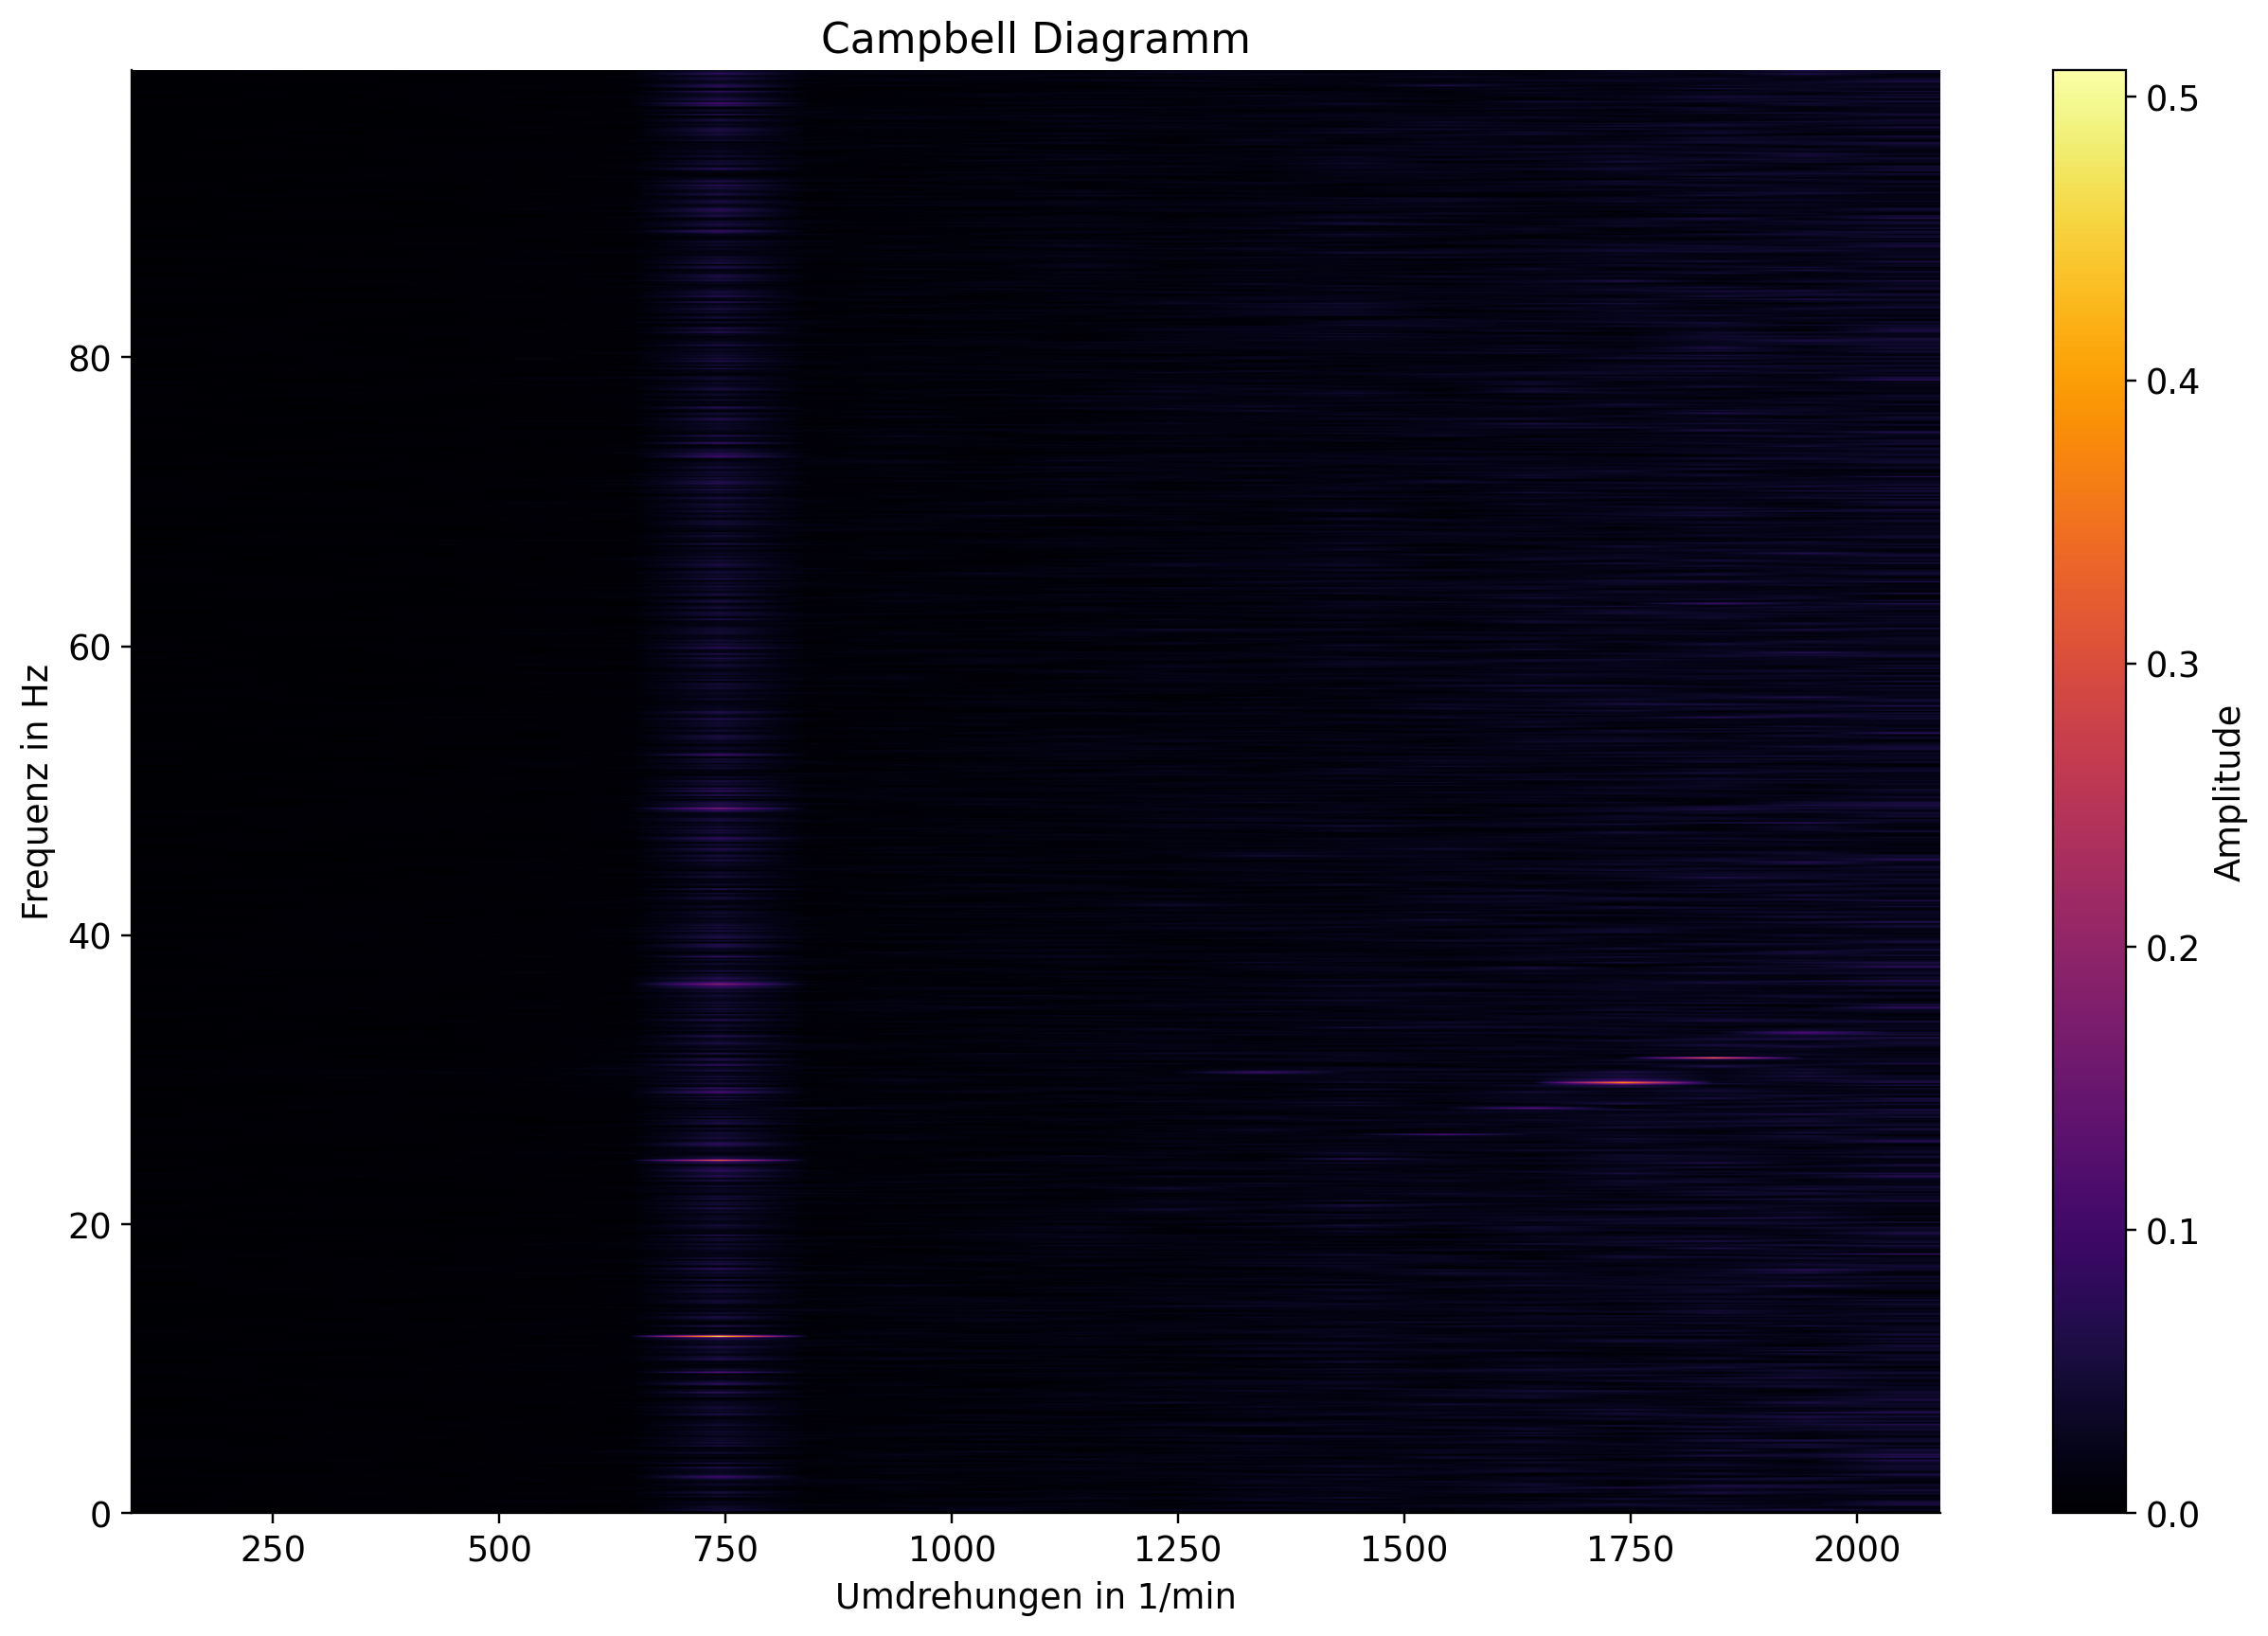

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 9))  

plt.imshow(amp_res, 
           extent=[min(rpm), 
                   max(rpm), 0, 
                   max(freq_ex)],  
           aspect="auto",  
           interpolation="bilinear",
           cmap="inferno",
           origin="lower"  
          )

#Beschriftung des Campbell_Diagramm
plt.xlabel("Umdrehungen in 1/min")
plt.ylabel("Frequenz in Hz") 
plt.colorbar(label="Amplitude")
plt.title("Campbell Diagramm")
plt.show()

## Zweiter Datensatz: Prüfstand 02

#### 1. Einlesen der Mess- und Metadaten

In [7]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_100928_lavalrotor_01_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_100928_lavalrotor_01_02.h5"  # name of the H5-file
h5_path=os.path.join(path_measurement_folder,filename)

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))
uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000
interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)  


file = h5py.File(os.path.join(path_measurement_folder, filename), "r")

acc_x = []
acc_y = []
acc_z = [] 
time = [] 
rpm = [] 


for i in range(len(file.keys())):
    
    for key in file.keys():
        
        if str(i) == key:
            acc_x.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_x"]))
            acc_y.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_y"]))
            acc_z.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_z"]))
            time.append(np.array(file[key]["RawData"][uuid_acceleration]["timestamp"]))
            rpm.append(np.array(file[key]["RawData"][uuid_motor_rpm]["motor_rpm"]))

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8511-6a0b-8cd5-972f083673c9": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [8]:
importlib.reload(m_postprocessing)  # reload functions

abs_acc = []
interp_data = []
fft_res = []

for i in range(len(acc_x)):
    #absolute Beschleunigung der Daten
    abs_acc.append(m_postprocessing.get_vec_accel(acc_x[i], acc_y[i], acc_z[i]))
    
    #Interpoliert Datenpunkte
    interp_data.append(m_postprocessing.interpolation(time[i], abs_acc[i], interpolation_points))

    #Führt eine Fast-Fourier-Transformation durch
    fft_res.append(m_postprocessing.my_fft_scaled(interp_data[i], interpolation_points))

freq_ex = fft_res[0][1]

amp_res = []

for i in fft_res:
    amp_res.append(i[0])
    
amp_res = np.array(amp_res)

amp_res = np.transpose(amp_res)

#### 3. Darstellung mittels Campbell-Diagramm

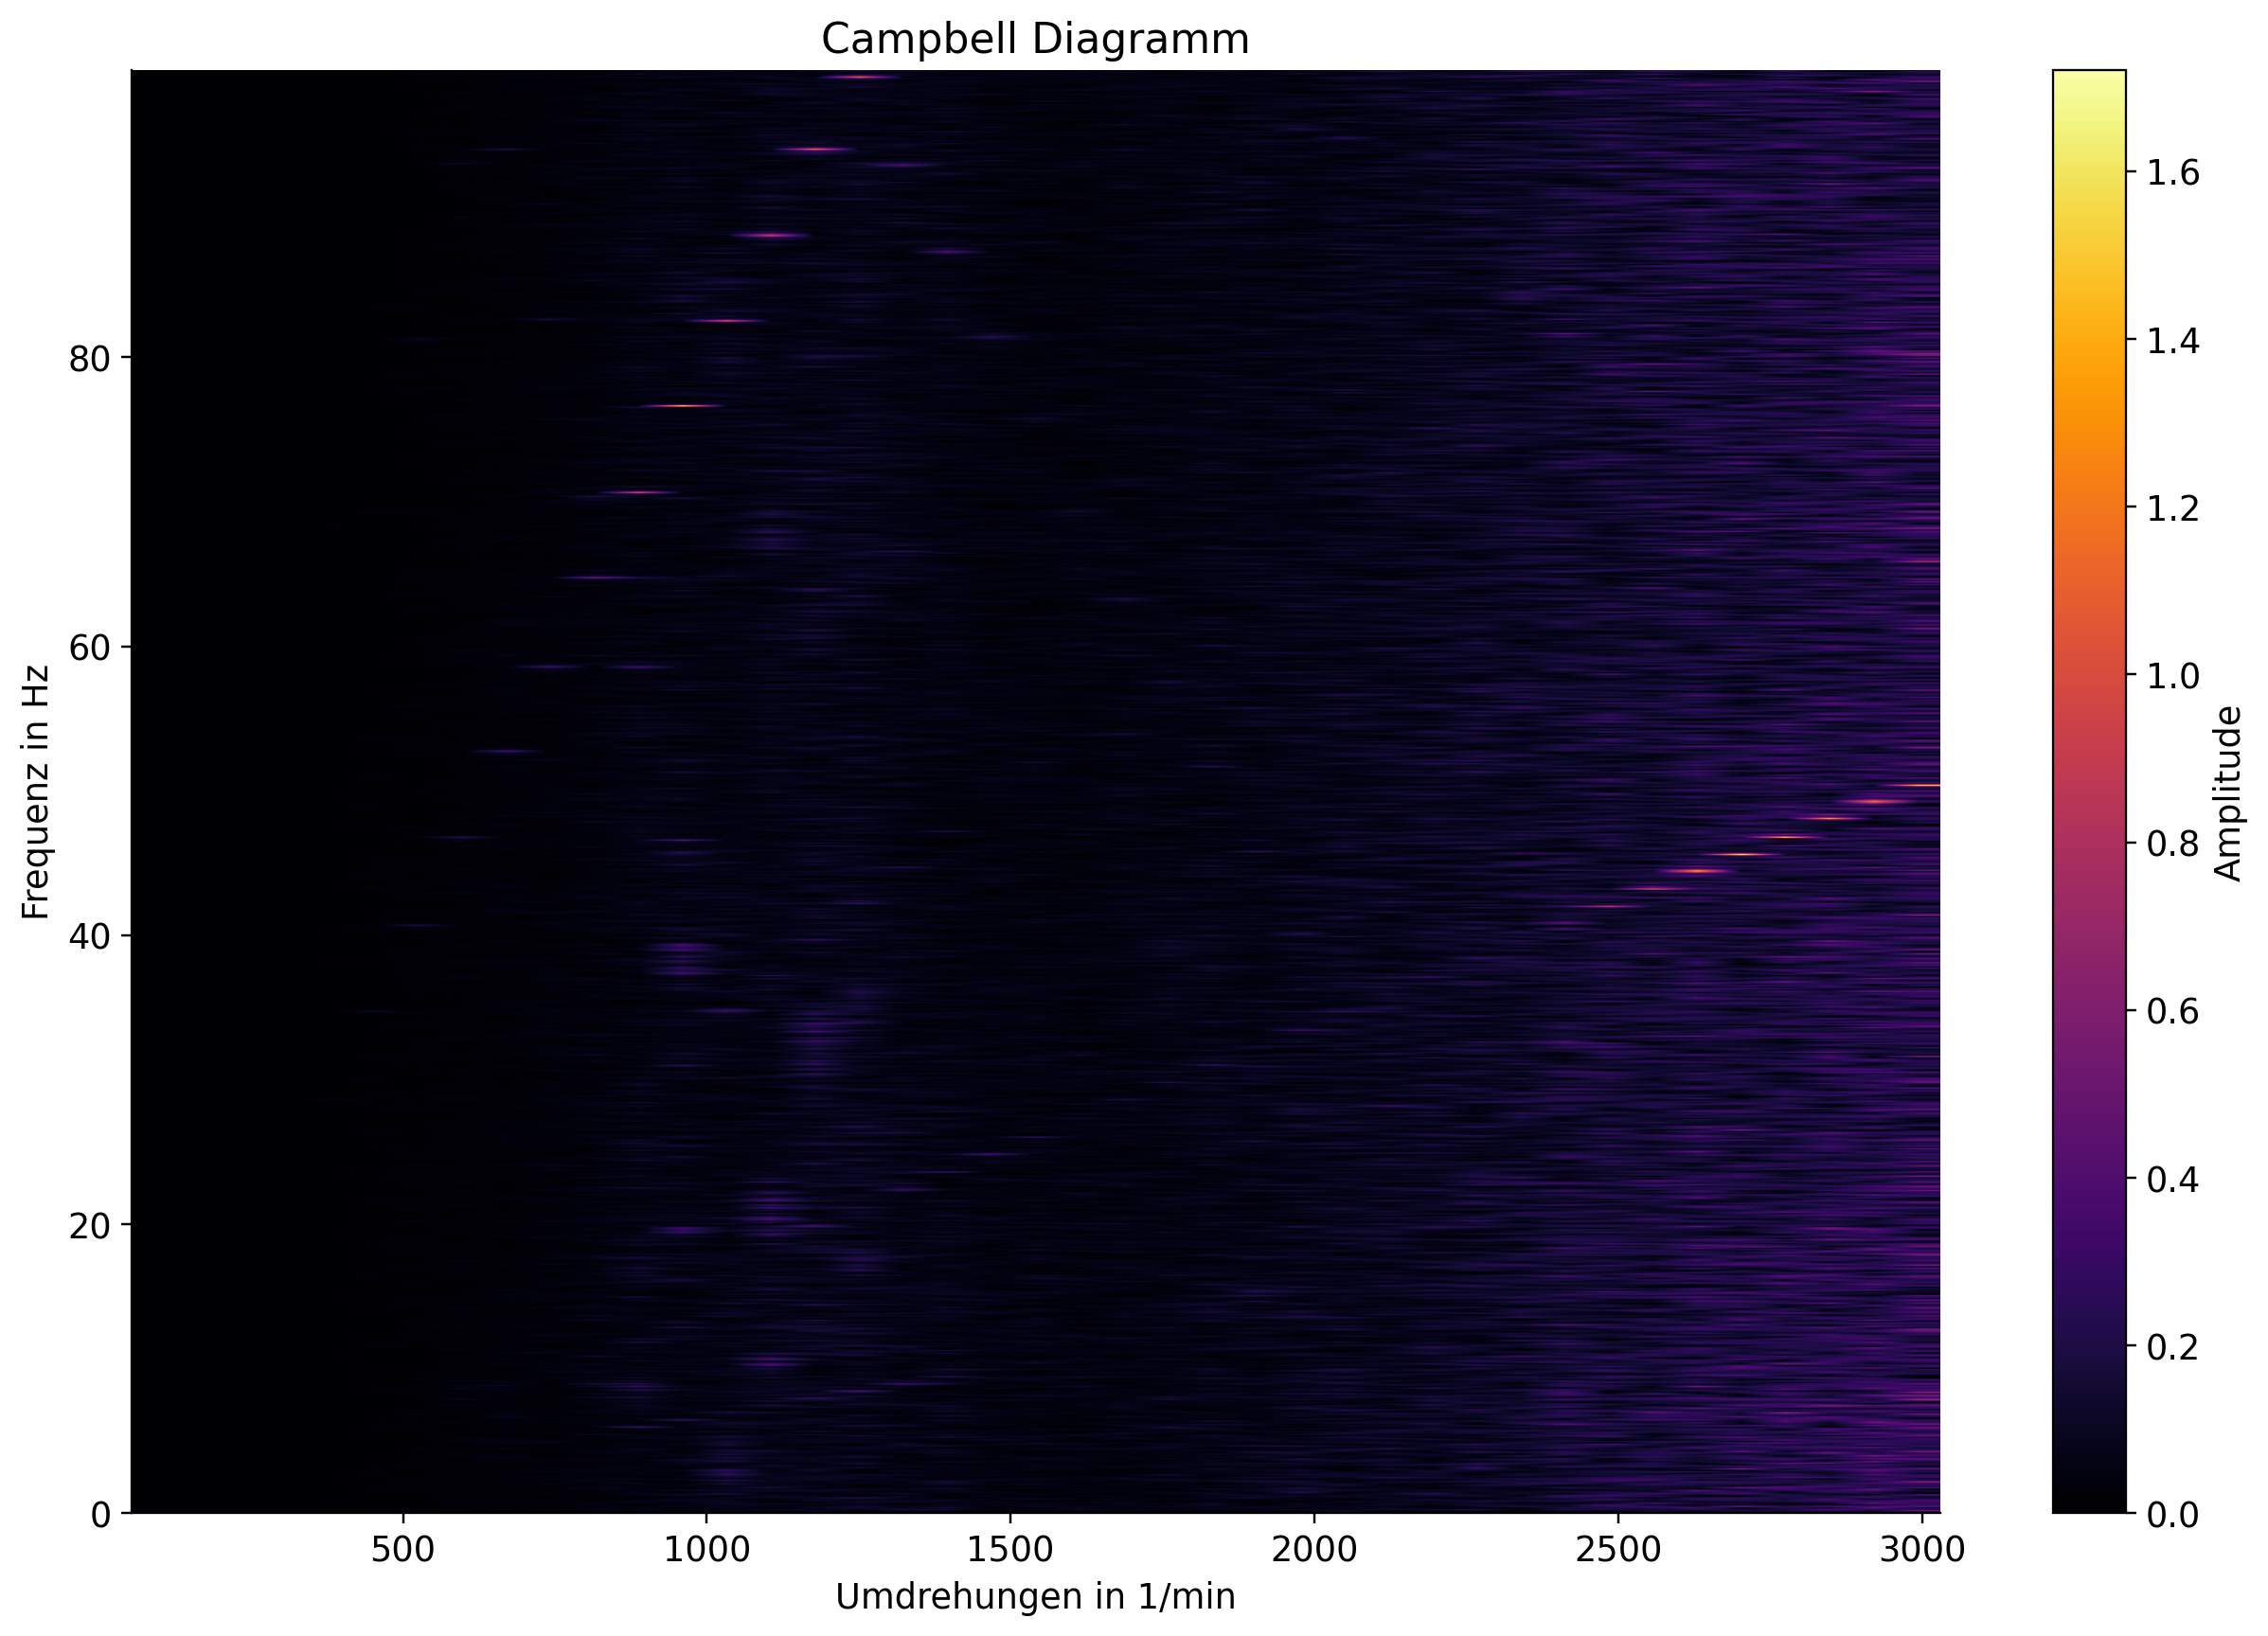

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 9))  

plt.imshow(amp_res, 
           extent=[min(rpm), 
                   max(rpm), 0, 
                   max(freq_ex)],  
           aspect="auto",  
           interpolation="bilinear",
           cmap="inferno",
           origin="lower"  
          )

#Beschriftung des Campbell-Diagramms 
plt.xlabel("Umdrehungen in 1/min")
plt.ylabel("Frequenz in Hz") 
plt.colorbar(label="Amplitude")
plt.title("Campbell Diagramm")
plt.show()

## Dritter Datensatz: Prüfstand 03

#### 1. Einlesen der Mess- und Metadaten

In [10]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_112539_lavalrotor_01_03.h5"  # name of the H5-file
h5_path=os.path.join(path_measurement_folder,filename)

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))
uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000
interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)  


file = h5py.File(os.path.join(path_measurement_folder, filename), "r")

acc_x = []
acc_y = []
acc_z = [] 
time = [] 
rpm = [] 


for i in range(len(file.keys())):
    
    for key in file.keys():
        
        if str(i) == key:
            acc_x.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_x"]))
            acc_y.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_y"]))
            acc_z.append(np.array(file[key]["RawData"][uuid_acceleration]["acceleration_z"]))
            time.append(np.array(file[key]["RawData"][uuid_acceleration]["timestamp"]))
            rpm.append(np.array(file[key]["RawData"][uuid_motor_rpm]["motor_rpm"]))

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [11]:
importlib.reload(m_postprocessing)  # reload functions

abs_acc = []
interp_data = []
fft_res = []

for i in range(len(acc_x)):
    #absolute Beschleunigung der Daten
    abs_acc.append(m_postprocessing.get_vec_accel(acc_x[i], acc_y[i], acc_z[i]))
    
    #Interpoliert Datenpunkte
    interp_data.append(m_postprocessing.interpolation(time[i], abs_acc[i], interpolation_points))

    #Führt eine Fast-Fourier-Transformation durch
    fft_res.append(m_postprocessing.my_fft_scaled(interp_data[i], interpolation_points))

freq_ex = fft_res[0][1]

amp_res = []

for i in fft_res:
    amp_res.append(i[0])
    
amp_res = np.array(amp_res)

amp_res = np.transpose(amp_res)

#### 3. Darstellung mittels Campbell-Diagramm

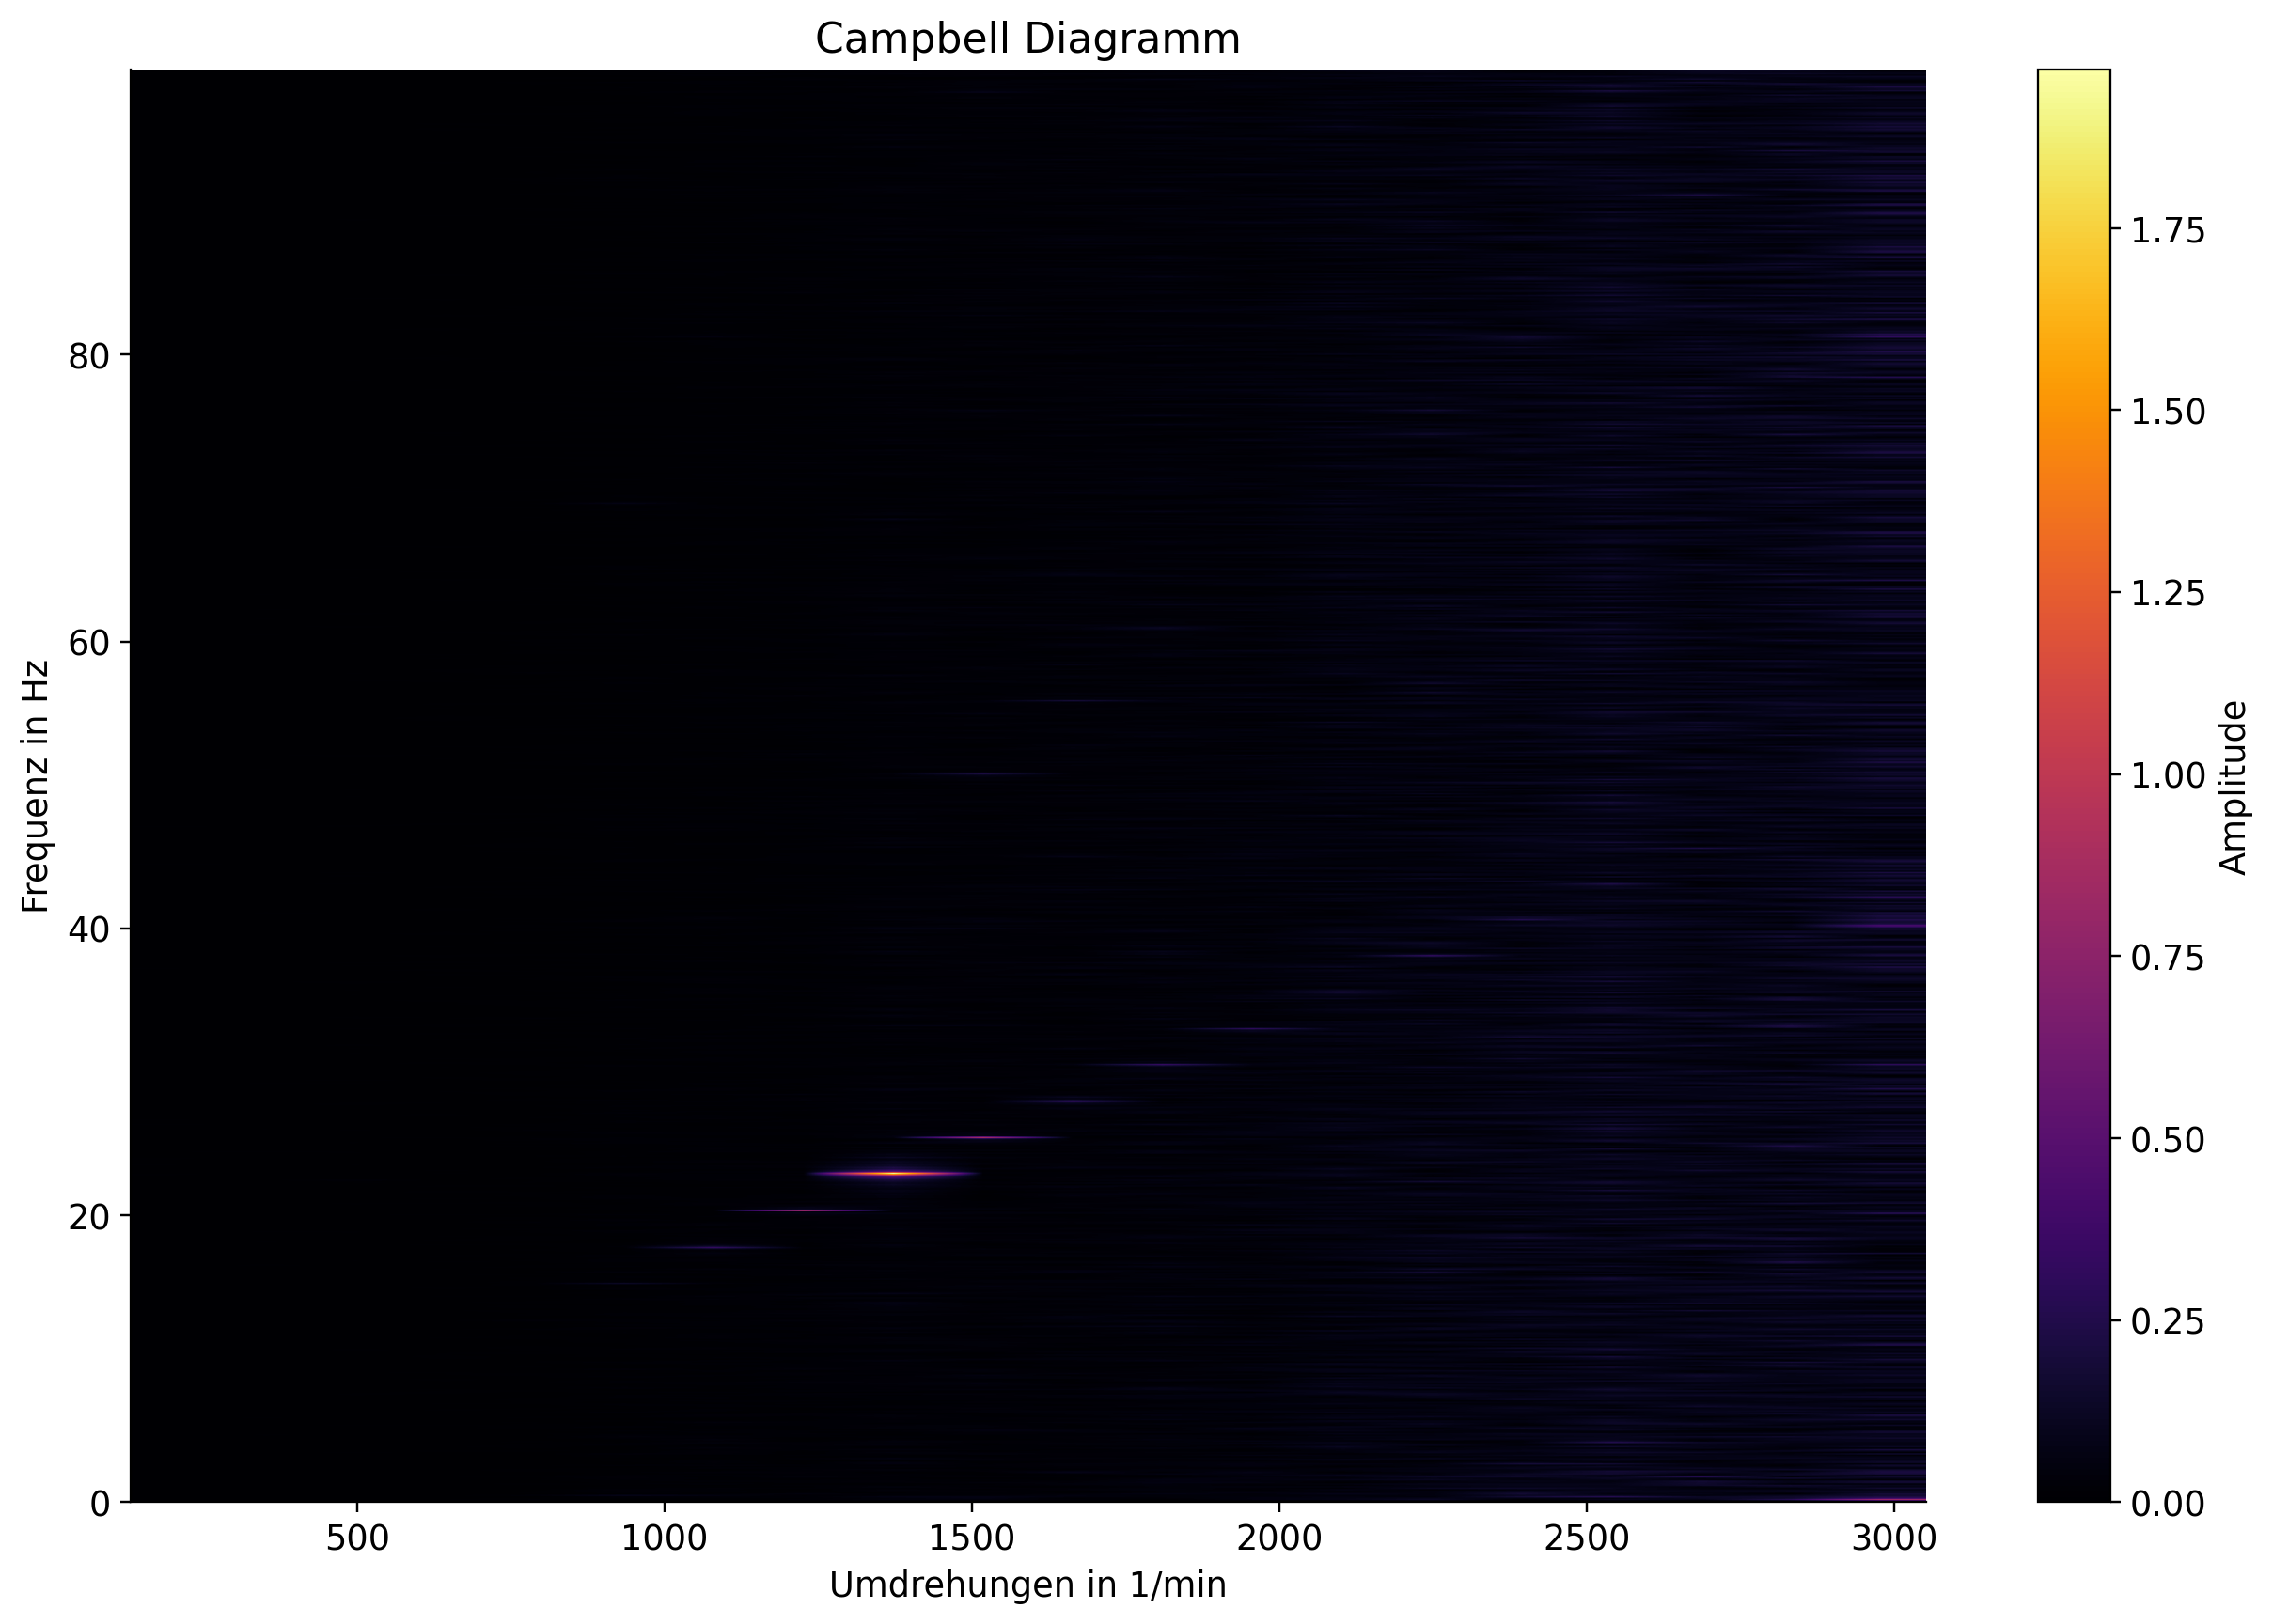

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 9))  

plt.imshow(amp_res, 
           extent=[min(rpm), 
                   max(rpm), 0, 
                   max(freq_ex)],  
           aspect="auto",  
           interpolation="bilinear",
           cmap="inferno",
           origin="lower"  
          )

#Beschriftung des Campbell-Diagramms 
plt.xlabel("Umdrehungen in 1/min")
plt.ylabel("Frequenz in Hz") 
plt.colorbar(label="Amplitude")
plt.title("Campbell Diagramm")
plt.show()

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Datensatz 1: kritische Drehzahl bei ca.

$$
\omega_{krit} = 750 \frac{U}{min}
$$

begleitet von einm relativ großen Nebenmaximum bei

$$\omega \thickapprox 1750 \frac{U}{min},$$ 

Dies deutet auf eine eher schlechte rotordynamische Stabilität hin, da analytisch nur eine kritische Drehzahl existiert.

In Datensatz 2 liegen die kritischen Drehzahlen bei etwa 

$$
\omega_{krit,1} = 1000 \frac{U}{min}, \omega_{krit,2} = 2600 \frac{U}{min},
$$

Aufgrund der geringeren Masse der beiden Scheiben erscheint es plausibel, dass diese Werte höher sind als die aus Datensatz 1. Dennoch zeigen auch hier das Vorhandensein einiger Nebenmaxima im Campbell-Diagramm auf eine potenziell instabile Rotordynamik hin.


Datensatz 3 offenbart eine kritische Drehzahl von knapp

$$
\omega_{krit} = 1500 \frac{U}{min},
$$

Obwohl einige Nebenmaxima auftreten, sind sie deutlich begrenzter als in den anderen Datensätzen. Dies deutet darauf hin, dass die rotordynamische Stabilität in diesem Szenario verbessert ist und die Amplitude klarer abgegrenzt werden kann.

Trotz der generellen suboptimalen Stabilität zeigen Datensatz 1 und 3 klare Amplituden in den Diagrammen. Datensatz 1 und 2 könnten jedoch zu verzerrten Ergebnissen führen, da sie relativ große Nebenmaxima aufweisen, die auf zusätzliche Drehzahlen hinweisen, obwohl nur eine (Datensatz 1) bzw. zwei (Datensatz 2) kritische Drehzahlen existieren.

Die Selbstzentrierungen können grundlegend durch abnehmende Amplituden nach dem Durchfahren der kritischen Drehzahlen der Rotoren identifiziert werden.

Das Campbell-Diagramm bietet eine ausgezeichnete Möglichkeit, die Messdaten zur Bestimmung und Darstellung kritischer Drehzahlen sowie zur Analyse der rotordynamischen Stabilität zu visualisieren.


##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

<img src="Bild/Rechnung.jpg" width="500">


Die kritische Drehzahl, die wir durch Berechnungen ermittelt haben, entspricht in etwa der Drehzahl, die wir direkt am Prüfstand ablesen können, nämlich 750 Umdrehungen pro Minute. Das deutet darauf hin, dass unsere Messungen zuverlässig sind, vorausgesetzt, wir ignorieren bestimmte zusätzliche Messungen, die wir gemacht haben. Trotzdem gibt es eine kleine Abweichung von etwa 90 Umdrehungen pro Minute. Diese Abweichung ist wahrscheinlich darauf zurückzuführen, dass wir bei unseren Berechnungen einige Annahmen gemacht haben, vor allem in Bezug auf die Steifigkeit der Welle.






## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

In dieser Lernheinheit habe ich vieles gelernt was ich davor nicht kannte, Drehzahlen, vorallem die kritische spielt in MM eine große Rolle dennoch wusste ich vor dieser Aufgabe nicht das man dieese in einem Diagramm so gut darstellen kann. Auch das vergleichen mehrerer Fälle gibt einen guten Ausblick darüber ob so ein Versuch uberhaupt auf andere Situation andwendbar oder vergleichbar ist. Ich konnte dazu mein Verständnis für die Analyse von Daten aus Schwingungsphänomen vertiefen und fand das Experiment äußerst interessant.